In [12]:
%load_ext autoreload
%autoreload 1
%aimport helpers, plotters, loaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# This might help with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [74]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [15]:
dataset = 'MNIST'
learner_type = 'BB'
loader_func = load_mnist
df = loader_func(preprocess=True)

Target column encoded with the following classes [ 4.  9.]
Dataset shape (13782, 785)
Value composition:
1    0.504861
0    0.495139
Name: target, dtype: float64


/home/jovyan/loaders.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


### Split data into training and testing

In [16]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [17]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## AdaBoost Model Complexity

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

base_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [39]:
param_grid = {
    'n_estimators': [1, 10, 20, 50, 100, 150, 200, 250, 300, 400],
    'base_estimator__max_depth': range(1, 6),
    'learning_rate': [.5, .75, 1.0]
}

In [9]:
grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 270 candidates, totalling 1080 fits
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.8785743887277249, total=   0.5s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.9025704809286899, total=   0.6s
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.8958938199917047, total=   0.5s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.9021153048527581, total=   0.6s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=10 .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=10, score=0.9564496059726255, total=   4.1s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=10, score=0.9477395271671506, total=   4.3s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.9585406301824212, total=   8.3s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.9581086686022398, total=   8.3s
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.9564857024450891, total=   8.6s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.9s


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.9709664039817503, total=   8.7s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.9796849087893864, total=  20.4s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.9718193120596768, total=  20.6s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.9755288262131896, total=  21.3s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.9829946080464538, total=  21.2s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100, score=0.9838308457

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100, score=0.9796764827872252, total=  43.2s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100, score=0.9834093737038573, total=  43.7s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150, score=0.9838308457711443, total= 1.0min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150, score=0.9834231247409864, total= 1.1min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150, score=0.9829946080464538, total= 1.1min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=150, score=0.98423

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.9850808122668877, total= 1.4min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.9859038142620232, total= 1.4min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.9834093737038573, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.9858979676482788, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250, score=0.9838375466224617, total= 1.9min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250, score=0.98424

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300, score=0.9854892205638475, total= 2.8min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300, score=0.9829946080464538, total= 2.8min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300, score=0.9900456242223143, total= 2.9min
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400, score=0.984251968503937, total= 3.0min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=1, score=0.8785743887277249, total=   0.5s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400, score=0.9863184

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min


[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.9519270617488603, total=   4.7s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.9444444444444444, total=   4.4s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.9576939029448361, total=   4.4s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.9593529655744505, total=   4.5s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20, score=0.966017405719022, total=   9.0s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20, score=0.963515

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 12.2min


[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=50, score=0.978441127694859, total=  23.3s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=50, score=0.9800912484446288, total=  22.4s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=50, score=0.9809207797594359, total=  22.6s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100, score=0.9792789059262329, total=  45.7s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100, score=0.981750311074243, total=  44.5s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=100, score=0

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 14.3min


[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.983008702859511, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.9809286898839138, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.9838241393612609, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.9867274989630859, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250, score=0.9821724709784412, total= 1.8min
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250, sco

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 22.6min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1, score=0.8785743887277249, total=   0.5s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=400, score=0.985495234148363, total= 3.0min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1, score=0.9025704809286899, total=   0.5s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1, score=0.8958938199917047, total=   0.7s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1, score=0.9021153048527581, total=   0.6s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10, score=0.95275590551181

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 23.0min


[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=400, score=0.9888013272501037, total= 3.1min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=20, score=0.9734549979261717, total=   9.3s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50, score=0.9813510153336096, total=  22.0s
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50, score=0.9805140961857379, total=  21.7s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=100 
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50, score=0.9697221070095396, total=  22.6s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=50, score=0.982579842

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 26.7min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.9842454394693201, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.9858979676482788, total= 1.6min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.9900456242223143, total= 1.5min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250, score=0.984251968503937, total= 1.8min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250, score=0.986318407960199, total= 1.8min
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250, score=0.9838241

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 33.8min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=400, score=0.9908789386401327, total= 2.9min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=1, score=0.9187059311489009, total=   0.9s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.9697472026523001, total=   5.9s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.9709784411276948, total=   5.9s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.9651596847781003, total=   5.6s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.97428452924

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 35.6min


[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=100, score=0.9842454394693201, total=  59.7s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=100, score=0.9896308585649108, total=  58.5s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=100, score=0.9850684363334716, total= 1.0min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150, score=0.985495234148363, total= 1.5min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150, score=0.9854892205638475, total= 1.5min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=150, score=0.985068

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 45.0min


[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=300, score=0.9888059701492538, total= 3.0min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=300, score=0.9879717959352966, total= 3.1min
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=400, score=0.9871529216742644, total= 3.7min
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1, score=0.9079983423124741, total=   0.8s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1, score=0.9237147595356551, total=   0.9s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=1, score=0.91538780

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 49.5min


[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.9805140961857379, total=  29.1s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.978017420157611, total=  29.9s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.9838241393612609, total=  28.7s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100, score=0.985495234148363, total=  57.2s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100, score=0.9854892205638475, total=  58.1s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100, score=0

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 56.0min


[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.9892205638474295, total= 2.2min
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.9883961873186904, total= 2.2min
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.987557030277893, total= 2.3min
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.9892160929075072, total= 2.9min
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400, score=0.9883961873186904, total= 3.8min
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1, score=0

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 63.2min


[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=50, score=0.9809286898839138, total=  29.0s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=50, score=0.9788469514724181, total=  29.0s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=50, score=0.9813355454168395, total=  28.4s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100, score=0.9846663903854124, total=  56.3s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100, score=0.9846600331674958, total=  57.2s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100, score=0.98589796

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 73.6min


[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=300, score=0.9908751555371216, total= 2.9min
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=300, score=0.987557030277893, total= 3.0min
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=400, score=0.986738499792789, total= 3.8min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1, score=0.9096560298383755, total=   0.8s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1, score=0.9336650082918739, total=   0.8s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=1, score=0.9265864786395

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 79.5min


[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=100, score=0.9842454394693201, total= 1.2min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=100, score=0.9821650767316467, total= 1.2min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=100, score=0.9854832019908751, total= 1.2min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150, score=0.985495234148363, total= 1.7min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150, score=0.9838308457711443, total= 1.7min
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=150, score=0.983409

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 94.4min


[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400, score=0.9879767827529021, total= 4.6min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=1, score=0.9344670261302365, total=   1.0s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10, score=0.9697472026523001, total=   6.3s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10, score=0.9751243781094527, total=   6.3s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10, score=0.969307341352136, total=   6.6s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=10, score=0.9755288

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 100.6min


[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200, score=0.9842389050186644, total= 2.2min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200, score=0.9867274989630859, total= 2.3min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250, score=0.9846663903854124, total= 2.8min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250, score=0.9875621890547264, total= 2.8min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250, score=0.9834093737038573, total= 2.8min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250, sc

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 111.9min


[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=20, score=0.9746992948983824, total=  13.2s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=20, score=0.9730402322687681, total=  13.6s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.9788644840447576, total=  36.5s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.9842389050186644, total=  35.5s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.9813432835820896, total=  36.2s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.98050601410

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 127.8min


[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1, score=0.937007874015748, total=   1.0s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1, score=0.9427860696517413, total=   1.0s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1, score=0.9440066362505185, total=   1.0s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1, score=0.9440066362505185, total=   1.1s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10, score=0.9680895151263986, total=   8.5s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=400, score=0.987557030277893

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 133.3min


[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=200, score=0.9863240779113137, total= 2.6min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=200, score=0.9888059701492538, total= 2.7min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=200, score=0.9838241393612609, total= 2.7min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=200, score=0.9896308585649108, total= 2.7min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250, score=0.9871529216742644, total= 3.3min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=250, score=0.98714

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 149.6min


[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=50, score=0.9854892205638475, total=  38.3s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=50, score=0.9788469514724181, total=  39.1s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=50, score=0.9863127333056823, total=  40.1s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100, score=0.9834231247409864, total= 1.3min
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100, score=0.9896351575456053, total= 1.3min
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=100, score

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 167.6min


[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10, score=0.9618731869042686, total=   7.8s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10, score=0.9684908789386402, total=   7.7s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10, score=0.9639153878058897, total=   7.9s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=10, score=0.9614267938614682, total=   8.1s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=400, score=0.9883865615927001, total= 5.2min
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=20, score=0.968089515

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 182.0min


[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=300, score=0.9896351575456053, total= 3.8min
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=300, score=0.9834093737038573, total= 3.9min
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=300, score=0.9888013272501037, total= 4.0min
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=400, score=0.9896351575456053, total= 4.7min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=400, score=0.986738499792789, total= 4.8min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=1, score=0.94529631

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 192.8min


[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=200, score=0.9846663903854124, total= 3.0min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=200, score=0.9888059701492538, total= 3.0min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=200, score=0.9858979676482788, total= 3.1min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=200, score=0.9896308585649108, total= 3.1min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250, score=0.9871529216742644, total= 3.7min
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=250, score=0.98590

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 212.5min


[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=100, score=0.9854892205638475, total= 1.5min
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=100, score=0.9829946080464538, total= 1.5min
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=100, score=0.9871422646204894, total= 1.5min
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150, score=0.9834231247409864, total= 2.2min
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150, score=0.9896351575456053, total= 2.2min
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=150, sc

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 232.3min


[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.9659892160929076, total=  18.1s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.975114060555786, total=  18.0s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50, score=0.9805140961857379, total=  43.9s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50, score=0.9788644840447576, total=  45.0s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50, score=0.9829946080464538, total=  43.6s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50, score=0.982579842389

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 253.4min


[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10, score=0.9730402322687681, total=  11.0s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=400, score=0.9900456242223143, total= 6.1min
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=400, score=0.9863127333056823, total= 6.1min
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20, score=0.9755491089929549, total=  20.6s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20, score=0.9751243781094527, total=  20.6s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20, score=0.974284529

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 278.3min


[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=1, score=0.9464952301949399, total=   1.3s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=1, score=0.956864371630029, total=   1.0s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.9622876087857439, total=  10.3s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.9635157545605307, total=  10.2s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.9643301534632932, total=  10.2s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.97221070

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 302.6min


[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1, score=0.9461251554082055, total=   1.2s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1, score=0.9519071310116086, total=   1.4s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1, score=0.9456656988801327, total=   1.3s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1, score=0.9581086686022398, total=   1.3s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=400, score=0.9883865615927001, total= 6.4min
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10, score=0.9656029838375

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 320.3min


[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=300, score=0.9863127333056823, total= 5.5min
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=300, score=0.9900456242223143, total= 5.5min
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=400, score=0.984251968503937, total= 6.4min
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1, score=0.9457107335267302, total=   1.4s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1, score=0.9560530679933665, total=   1.3s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=1, score=0.948154292824

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 346.6min


[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=300, score=0.9829946080464538, total= 5.1min
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=300, score=0.9859038142620232, total= 5.3min
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=300, score=0.987557030277893, total= 5.4min
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400, score=0.9838375466224617, total= 7.1min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=1, score=0.947782842934107, total=   1.5s
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=1, score=0.955638474

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 368.3min


[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=300, score=0.9859096560298384, total= 5.0min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=300, score=0.9863127333056823, total= 5.1min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=300, score=0.9888059701492538, total= 5.2min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=300, score=0.9917046868519287, total= 5.1min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400, score=0.9846663903854124, total= 6.9min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=1, score=

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 398.7min


[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=300, score=0.9896351575456053, total= 5.0min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=300, score=0.9858979676482788, total= 5.1min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=300, score=0.990460389879718, total= 5.1min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400, score=0.985495234148363, total= 6.5min
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=1, score=0.9519270617488603, total=   1.4s
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=1, score=0.95812603648

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 428.1min


[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=300, score=0.9821650767316467, total= 6.4min
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=300, score=0.9829946080464538, total= 6.3min
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=400, score=0.983008702859511, total= 8.1min
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1, score=0.9498549523414836, total=   1.4s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1, score=0.9577114427860697, total=   1.4s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=1, score=0.950228121

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 462.7min


[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1, score=0.9531703273932863, total=   1.3s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1, score=0.9593698175787728, total=   1.2s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1, score=0.9493985897967648, total=   1.2s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=1, score=0.9647449191206968, total=   1.2s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=400, score=0.9892205638474295, total= 6.7min
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=400, score=0.98631273330

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 488.5min


[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=1, score=0.962671090833679, total=   1.5s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10, score=0.9701616245337754, total=  13.9s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=400, score=0.9871422646204894, total= 6.9min
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10, score=0.9697346600331676, total=  13.7s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=20 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=10, score=0.9684778100373289, total=  14.2s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=20 
[CV]  base_estim

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 521.0min


[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=10, score=0.9742845292409789, total=  12.7s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20, score=0.9759635308744302, total=  24.5s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20, score=0.978441127694859, total=  22.7s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20, score=0.9767731231854002, total=  25.8s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=20, score=0.9838241393612609, total=  23.3s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=400, sco

[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50 


[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 549.1min


[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=20, score=0.9784321858150146, total=  23.3s
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400, score=0.9900456242223143, total= 7.0min
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50 
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50, score=0.983008702859511, total=  55.5s
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50, score=0.9838308457711443, total=  53.0s
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50, score=0.9800912484446288, total=  53.9s
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=50, score=0.9

In [ ]:
save_search_result(grid_search, dataset, learner_type)

### Analysis

In [20]:
res = load_best_search(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['0.990_MNIST_BB_2018-09-14_03:43-04:00.pkl']
Returning results for the highest-scoring-file: 0.990_MNIST_BB_2018-09-14_03:43-04:00.pkl


mean_fit_time  \
base_estimator__max_depth learning_rate n_estimators                  
4                         1.00          400              303.283075   
                          0.50          400              301.248227   
3                         1.00          400              244.139483   
                          0.75          400              242.785096   
4                         0.75          400              301.154259   
3                         0.75          250              153.704570   
5                         1.00          400              333.445936   
                          0.75          300              262.185480   
3                         0.75          300              185.402283   
5                         1.00          250              218.686177   

                                                      std_fit_time  \
base_estimator__max_depth learning_rate n_estimators                 
4                         1.00          400               3.979702   
                          0.50          400               3.297627   
3                         1.00          400               2.518114   
                          0.75          400               3.456434   
4                         0.75          400               4.279101   
3                         0.75          250               2.129498   
5                         1.00          400               0.837508   
                          0.75          300               3.237633   
3                         0.75          300               2.192310   
5                         1.00          250               1.884904   

                                                      mean_score_time  \
base_estimator__max_depth learning_rate n_estimators                    
4                         1.00          400                  0.821728   
                          0.50          400                  0.794769   
3                         1.00          400                  0.764245   
                          0.75          400                  0.755285   
4                         0.75          400                  0.804226   
3                         0.75          250                  0.477826   
5                         1.00          400                  0.665973   
                          0.75          300                  0.638343   
3                         0.75          300                  0.587486   
5                         1.00          250                  0.530226   

                                                      std_score_time  \
base_estimator__max_depth learning_rate n_estimators                   
4                         1.00          400                 0.032943   
                          0.50          400                 0.022985   
3                         1.00          400                 0.009116   
                          0.75          400                 0.039976   
4                         0.75          400                 0.013228   
3                         0.75          250                 0.008881   
5                         1.00          400                 0.154631   
                          0.75          300                 0.021377   
3                         0.75          300                 0.058725   
5                         1.00          250                 0.029435   

                                                      mean_test_score  \
base_estimator__max_depth learning_rate n_estimators                    
4                         1.00          400                  0.989530   
                          0.50          400                  0.988908   
3                         1.00          400                  0.988908   
                          0.75          400                  0.988908   
4                         0.75          400                  0.988597   
3                         0.75          250                  0.988597   
5                         1.00    

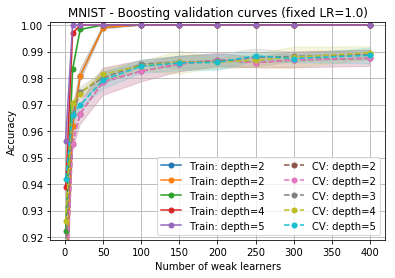

In [37]:
lr1= res_df.xs(1.0, level='learning_rate')
lr0_5 = res_df.xs(0.5, level='learning_rate')
lr0_75 = res_df.xs(0.5, level='learning_rate')

xs = lr1

mean_train, std_train, mean_test, std_test, mean_fit, std_fit, mean_score, std_score = {},{},{},{},{},{},{},{}

for d in param_grid['base_estimator__max_depth']:
    mean_train[d] = xs.xs(d, level='base_estimator__max_depth')['mean_train_score']
    std_train[d] = xs.xs(d, level='base_estimator__max_depth')['std_train_score']
    mean_test[d] = xs.xs(d, level='base_estimator__max_depth')['mean_test_score']
    std_test[d] = xs.xs(d, level='base_estimator__max_depth')['std_test_score']
    mean_fit[d] = xs.xs(d, level='base_estimator__max_depth')['mean_fit_time']
    std_fit[d] = xs.xs(d, level='base_estimator__max_depth')['std_fit_time']
    mean_score[d] = xs.xs(d, level='base_estimator__max_depth')['mean_score_time']
    std_score[d] = xs.xs(d, level='base_estimator__max_depth')['std_score_time']

means = [
    lr1.xs(2, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(3, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(4, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(5, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['mean_test_score'],
    lr1.xs(2, level='base_estimator__max_depth')['mean_test_score'],
    lr1.xs(3, level='base_estimator__max_depth')['mean_test_score'],
    lr1.xs(4, level='base_estimator__max_depth')['mean_test_score'],
    lr1.xs(5, level='base_estimator__max_depth')['mean_test_score'],
]

stds = [
    lr1.xs(2, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(3, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(4, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(5, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['std_test_score'],
    lr1.xs(2, level='base_estimator__max_depth')['std_test_score'],
    lr1.xs(3, level='base_estimator__max_depth')['std_test_score'],    
    lr1.xs(4, level='base_estimator__max_depth')['std_test_score'],
    lr1.xs(5, level='base_estimator__max_depth')['std_test_score'],    
]

series_labels = [
    'Train: depth=2',
    'Train: depth=2',
    'Train: depth=3',
    'Train: depth=4',
    'Train: depth=5',
    'CV: depth=2',
    'CV: depth=2',
    'CV: depth=3',
    'CV: depth=4',
    'CV: depth=5',
]

plot_means_w_stds(
    means,
    stds,
    param_grid['n_estimators'],
    series_labels=series_labels,
    legend=True,
    legend_kwargs={'ncol': 2},
    fig_kwargs={'figsize': (6,4)},
    ylim=[0.919, 1.001],
    xlabel='Number of weak learners',
    ylabel='Accuracy',
    title='MNIST - Boosting validation curves (fixed LR=1.0)'
)

### Timing Analysis

In [44]:
list(param_grid['base_estimator__max_depth'])

[1, 2, 3, 4, 5]

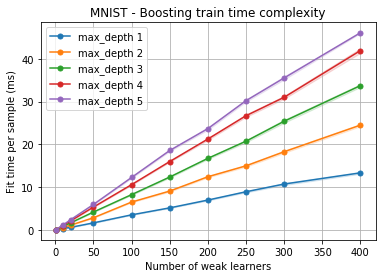

In [76]:
means = [mean_fit[d] for d in param_grid['base_estimator__max_depth']]
stds = [std_fit[d] for d in param_grid['base_estimator__max_depth']]
labels = ['max_depth %i' % i for i in param_grid['base_estimator__max_depth']]

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] * 3/4 # three-quarters of dataset was fit for 4-fold validation
# convert to milliseconds
means_per_samp = [mean_fit[d] / n_samples * 1000 for d in param_grid['base_estimator__max_depth']]
stds_per_samp = [std_fit[d] / n_samples * 1000  for d in param_grid['base_estimator__max_depth']]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['n_estimators'],
    series_labels=labels,
    title='MNIST - Boosting train time complexity',
    legend_kwargs={'loc': 'best'},
    ylabel='Fit time per sample (ms)',
    xlabel='Number of weak learners',
#     fig_kwargs={'figsize': (10,6)},
)

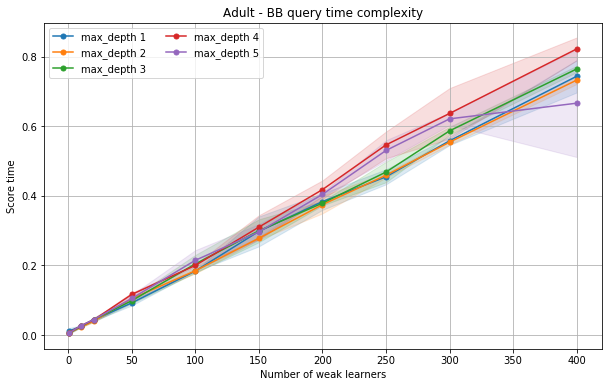

In [51]:
means = [mean_score[d] for d in param_grid['base_estimator__max_depth']]
stds = [std_score[d] for d in param_grid['base_estimator__max_depth']]

plot_means_w_stds(
    means,
    stds,
    param_grid['n_estimators'],
    series_labels=['max_depth %i' % i for i in param_grid['base_estimator__max_depth']],
    title='Adult - BB query time complexity',
    legend_kwargs={'loc': 'best', 'ncol': 2},
    ylabel='Score time',
    xlabel='Number of weak learners',
    fig_kwargs={'figsize': (10,6)},
)

Fit time is important for this dataset. Let's sort sufficiently accurate models by fit time.

In [55]:
res_df[res_df['mean_test_score'] >= np.max(res_df['mean_test_score']) * (.999)].sort_values(by='mean_fit_time')

mean_fit_time  \
base_estimator__max_depth learning_rate n_estimators                  
3                         0.75          250              153.704570   
                                        400              242.785096   
                          1.00          400              244.139483   
5                         0.75          300              262.185480   
4                         0.75          400              301.154259   
                          0.50          400              301.248227   
                          1.00          400              303.283075   
5                         1.00          400              333.445936   

                                                      std_fit_time  \
base_estimator__max_depth learning_rate n_estimators                 
3                         0.75          250               2.129498   
                                        400               3.456434   
                          1.00          400               2.518114   
5                         0.75          300               3.237633   
4                         0.75          400               4.279101   
                          0.50          400               3.297627   
                          1.00          400               3.979702   
5                         1.00          400               0.837508   

                                                      mean_score_time  \
base_estimator__max_depth learning_rate n_estimators                    
3                         0.75          250                  0.477826   
                                        400                  0.755285   
                          1.00          400                  0.764245   
5                         0.75          300                  0.638343   
4                         0.75          400                  0.804226   
                          0.50          400                  0.794769   
                          1.00          400                  0.821728   
5                         1.00          400                  0.665973   

                                                      std_score_time  \
base_estimator__max_depth learning_rate n_estimators                   
3                         0.75          250                 0.008881   
                                        400                 0.039976   
                          1.00          400                 0.009116   
5                         0.75          300                 0.021377   
4                         0.75          400                 0.013228   
                          0.50          400                 0.022985   
                          1.00          400                 0.032943   
5                         1.00          400                 0.154631   

                                                      mean_test_score  \
base_estimator__max_depth learning_rate n_estimators                    
3                         0.75          250                  0.988597   
                                        400                  0.988908   
                          1.00          400                  0.988908   
5                         0.75          300                  0.988597   
4                         0.75          400                  0.988597   
                          0.50          400                  0.988908   
                          1.00          400                  0.989530   
5                         1.00          400                  0.988597   

                                                      std_test_score  \
base_estimator__max_depth learning_rate n_estimators                   
3                         0.75          250                 0.001480   
                                        400                 0.000796   
                          1.00          400                 0.001717   
5                         0.75          300                 0.001770   
4                         0

## Boosting Learning Curve Analysis

#### What is the best estimator

In [67]:
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=4),
    n_estimators=400,
    learning_rate=1.0,
)

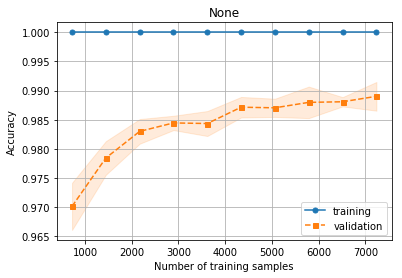

In [68]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, n_jobs=-1)

#### What is the preferred estimator
depth=3	LR=0.75	n_estimators=250 trained in half the time and had mean test score within 0.1% of the best performer.

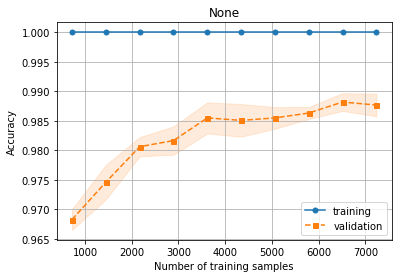

In [56]:
clf2 = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=250,
    learning_rate=0.75,
)
train_sizes2, train_mean2, train_std2, test_mean2, test_std2 = gen_and_plot_learning_curve(clf2, X_train_scaled, y_train, ylim=None, cv=4, n_jobs=-1)

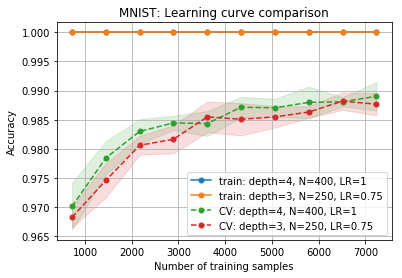

In [69]:
plot_means_w_stds(
    (train_mean, train_mean2, test_mean, test_mean2),
    (train_std, train_std2, test_std, test_std2),
    train_sizes,
    xlabel='Number of training samples',
    ylabel='Accuracy',
    series_labels=['train: depth=4, N=400, LR=1', 'train: depth=3, N=250, LR=0.75', 'CV: depth=4, N=400, LR=1', 'CV: depth=3, N=250, LR=0.75'],
    title='MNIST: Learning curve comparison'
)

# Performance on Test Set

In [75]:
best_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=4),
    n_estimators=400,
    learning_rate=1.0,
    random_state=1
)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_test_pred)
print('%.4f' % test_score)

0.9898
